In [0]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as trans
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

trainset = dsets.MNIST(root='../data/mnist',train=True,transform=trans.ToTensor(),download=True)
testset = dsets.MNIST(root='../data/mnist',train=False,transform=trans.ToTensor(),download=True)

trainset.data = trainset.data[0:1000]
trainset.targets = trainset.targets[0:1000]

train_loader = DataLoader(trainset,batch_size=128,shuffle=True,num_workers=6)
test_loader = DataLoader(testset,batch_size=128,shuffle=False,num_workers=6)


In [0]:
def eval(model,criterion,dataloader):
  model.eval()
  loss,acc = 0,0
  for bx,by in dataloader:
    bx,by = bx.to(device),by.to(device)
    bx = bx.view(-1,784)
    logit = model(bx)
    err = criterion(logit,by)
    loss += err.item()
    _,pred_y = logit.max(dim=1)
    acc += (pred_y==by).float().sum()/bx.size(0)

  loss /= len(dataloader)
  acc /= len(dataloader)
  return loss,acc

def train_epoch(model,optimizer,criterion,dataloader):
  model.train()
  for bx,by in dataloader:
    bx,by = bx.to(device),by.to(device)
    bx = bx.view(-1,784)
    logit = model(bx)
    err = criterion(logit,by)
    err.backward()
    optimizer.step()
    optimizer.zero_grad()



WeightDecay

BatchNormalization

DropOut

In [32]:
net1 = nn.Sequential(   # no batch normalization
    nn.Linear(784,500),
    nn.ReLU(),
    nn.Linear(500,500),
    nn.ReLU(),
    nn.Linear(500,300),
    nn.ReLU(),
    nn.Linear(300,10)
)
net2 = nn.Sequential(   # batch normalization
    nn.Linear(784,500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Linear(500,500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Linear(500,300),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300,10)
)
nepoch = 15
net1.to(device)
net2.to(device)
optimizer1 = torch.optim.SGD(net1.parameters(),lr=0.1,momentum=0.9)
optimizer2 = torch.optim.SGD(net2.parameters(),lr=0.1,momentum=0.9)
learn_hist1 = []
learn_hist2 = []
for epoch in range(nepoch):
  train_epoch(net1,optimizer1,criterion,train_loader)
  train_loss,train_acc = eval(net1,criterion,train_loader)
  test_loss,test_acc = eval(net1,criterion,test_loader)
  print("[%3d/%d] \t| train_loss:%.3f train_acc:%.3f \t| test_loss:%.3f test_acc:%.3f"%(
      epoch+1,nepoch,train_loss,train_acc*100,test_loss,test_acc*100
  ))
  learn_hist1.append((train_loss,train_acc,test_loss,test_acc))

for epoch in range(nepoch):
  train_epoch(net2,optimizer2,criterion,train_loader)
  train_loss,train_acc = eval(net2,criterion,train_loader)
  test_loss,test_acc = eval(net2,criterion,test_loader)
  print("[%3d/%d] \t| train_loss:%.3f train_acc:%.3f \t| test_loss:%.3f test_acc:%.3f"%(
      epoch+1,nepoch,train_loss,train_acc*100,test_loss,test_acc*100
  ))
  learn_hist2.append((train_loss,train_acc,test_loss,test_acc))


[  1/15] 	| train_loss:2.279 train_acc:20.741 	| test_loss:2.283 test_acc:18.859
[  2/15] 	| train_loss:2.197 train_acc:31.671 	| test_loss:2.211 test_acc:28.006
[  3/15] 	| train_loss:1.686 train_acc:66.248 	| test_loss:1.731 test_acc:62.915
[  4/15] 	| train_loss:0.727 train_acc:75.068 	| test_loss:0.865 test_acc:70.807
[  5/15] 	| train_loss:0.588 train_acc:81.813 	| test_loss:0.825 test_acc:74.011
[  6/15] 	| train_loss:0.395 train_acc:87.432 	| test_loss:0.625 test_acc:79.777
[  7/15] 	| train_loss:0.260 train_acc:92.225 	| test_loss:0.617 test_acc:81.210
[  8/15] 	| train_loss:0.202 train_acc:92.788 	| test_loss:0.616 test_acc:82.585
[  9/15] 	| train_loss:0.120 train_acc:96.342 	| test_loss:0.561 test_acc:84.573
[ 10/15] 	| train_loss:0.083 train_acc:97.371 	| test_loss:0.531 test_acc:86.116
[ 11/15] 	| train_loss:0.063 train_acc:98.415 	| test_loss:0.557 test_acc:86.224
[ 12/15] 	| train_loss:0.026 train_acc:99.512 	| test_loss:0.618 test_acc:85.631
[ 13/15] 	| train_loss:0.016

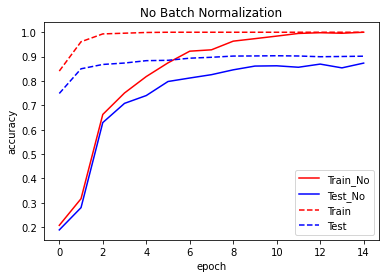

In [33]:
plt.plot([t[1] for t in learn_hist1],'r',label='Train_No')
plt.plot([t[3] for t in learn_hist1],'b',label='Test_No')
plt.plot([t[1] for t in learn_hist2],'r--',label='Train')
plt.plot([t[3] for t in learn_hist2],'b--',label='Test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('No Batch Normalization')
plt.legend()


In [36]:
p = 0.7
net1 = nn.Sequential(   # no batch normalization
    nn.Linear(784,500),
    nn.ReLU(),
    nn.Linear(500,500),
    nn.ReLU(),
    nn.Linear(500,300),
    nn.ReLU(),
    nn.Linear(300,10)
).to(device)
net2 = nn.Sequential(   # drop out
    nn.Linear(784,5000),
    nn.Dropout(p),
    nn.ReLU(),
    nn.Linear(5000,5000),
    nn.Dropout(p),
    nn.ReLU(),
    nn.Linear(5000,3000),
    nn.Dropout(p),
    nn.ReLU(),
    nn.Linear(3000,10)
).to(device)
nepoch = 15
net1.to(device)
net2.to(device)
optimizer1 = torch.optim.SGD(net1.parameters(),lr=0.1,momentum=0.9)
optimizer2 = torch.optim.SGD(net2.parameters(),lr=0.1,momentum=0.9)
learn_hist1 = []
learn_hist2 = []
for epoch in range(nepoch):
  train_epoch(net1,optimizer1,criterion,train_loader)
  train_loss,train_acc = eval(net1,criterion,train_loader)
  test_loss,test_acc = eval(net1,criterion,test_loader)
  print("[%3d/%d] \t| train_loss:%.3f train_acc:%.3f \t| test_loss:%.3f test_acc:%.3f"%(
      epoch+1,nepoch,train_loss,train_acc*100,test_loss,test_acc*100
  ))
  learn_hist1.append((train_loss,train_acc,test_loss,test_acc))

for epoch in range(nepoch):
  train_epoch(net2,optimizer2,criterion,train_loader)
  train_loss,train_acc = eval(net2,criterion,train_loader)
  test_loss,test_acc = eval(net2,criterion,test_loader)
  print("[%3d/%d] \t| train_loss:%.3f train_acc:%.3f \t| test_loss:%.3f test_acc:%.3f"%(
      epoch+1,nepoch,train_loss,train_acc*100,test_loss,test_acc*100
  ))
  learn_hist2.append((train_loss,train_acc,test_loss,test_acc))


[  1/15] 	| train_loss:2.277 train_acc:33.706 	| test_loss:2.281 test_acc:30.864
[  2/15] 	| train_loss:2.191 train_acc:38.229 	| test_loss:2.205 test_acc:34.246
[  3/15] 	| train_loss:1.668 train_acc:57.625 	| test_loss:1.712 test_acc:53.402
[  4/15] 	| train_loss:0.702 train_acc:76.593 	| test_loss:0.837 test_acc:71.479
[  5/15] 	| train_loss:0.897 train_acc:72.852 	| test_loss:1.192 test_acc:68.631
[  6/15] 	| train_loss:0.527 train_acc:84.337 	| test_loss:0.717 test_acc:76.909
[  7/15] 	| train_loss:0.350 train_acc:88.619 	| test_loss:0.656 test_acc:80.449
[  8/15] 	| train_loss:0.245 train_acc:92.330 	| test_loss:0.636 test_acc:82.002
[  9/15] 	| train_loss:0.141 train_acc:96.004 	| test_loss:0.487 test_acc:86.046
[ 10/15] 	| train_loss:0.146 train_acc:95.688 	| test_loss:0.653 test_acc:82.625
[ 11/15] 	| train_loss:0.091 train_acc:97.251 	| test_loss:0.568 test_acc:84.869
[ 12/15] 	| train_loss:0.041 train_acc:98.828 	| test_loss:0.564 test_acc:86.748
[ 13/15] 	| train_loss:0.021

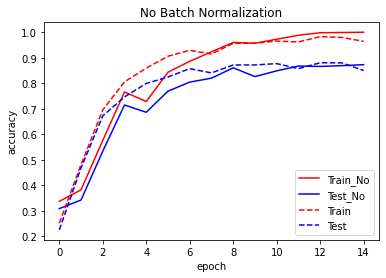

In [37]:
plt.plot([t[1] for t in learn_hist1],'r',label='Train_No')
plt.plot([t[3] for t in learn_hist1],'b',label='Test_No')
plt.plot([t[1] for t in learn_hist2],'r--',label='Train')
plt.plot([t[3] for t in learn_hist2],'b--',label='Test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('No Batch Normalization')
plt.legend()